<a href="https://colab.research.google.com/github/Coolershock/TPBuscaYerba/blob/main/Clasifica_yerba_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Coolershock/TPBuscaYerba/

fatal: destination path 'TPBuscaYerba' already exists and is not an empty directory.


In [2]:
import sys
import os
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses

In [3]:
print(tensorflow.__version__)

2.6.0


Importamos las librerías necesarias

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D

Limpiamos cualquier corrida anterior

In [5]:
from tensorflow.keras import backend as k
k.clear_session()

indicamos la ubicación de los datos de entrenamiento y los datos de validación

In [6]:
datos_entrenamiento='/content/TPBuscaYerba/ds4/entrenamiento'
datos_validacion='/content/TPBuscaYerba/ds4/validacion'

Definimos los parámetros que vamos a utilizar

In [7]:
##Parámetros
epocas=12
altura, longitud = 100,100
batch_size=7
batch_size_val=2
pasos=7
pasos_val=200
filtros_conv1=32
filtros_conv2=64
tam_fil1=(3,3)
tam_fil2=(2,2)
tam_pool=(2,2)
clases=2
lr=0.0005

Preprocesamiento de imágenes

In [8]:
##Preprocesamiento de imágenes
entrenamiento_datagen= ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
   horizontal_flip=True
)

validacion_datagen=ImageDataGenerator(
    rescale=1./255
)

imagen_entrenamiento= entrenamiento_datagen.flow_from_directory(
    datos_entrenamiento,
    target_size=(altura,longitud),
    batch_size=batch_size,
    class_mode='binary'
)

imagen_validacion= validacion_datagen.flow_from_directory(
    datos_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size_val,
    class_mode='binary'
)

Found 54 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


Probando una CNN Simple

In [9]:
##Creamos la Red CNN
## cnn=Sequential()
## cnn.add(Convolution2D(filtros_conv1, tam_fil1, padding='same', input_shape=(altura,longitud,3), activation='relu'))
## cnn.add(MaxPooling2D(pool_size=tam_pool))
## cnn.add(Convolution2D(filtros_conv2, tam_fil2, padding='same', activation='relu'))
## cnn.add(MaxPooling2D(pool_size=tam_pool))

Prueba de función vgg16 y vgg19, ambos modelos preeentrenados para clasificación de imágenes con pesos que se descargan al instanciar el modelo

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

modelo_vgg16 = VGG16(weights='imagenet', include_top=False,  input_shape=(100, 100, 3))

modelo_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [11]:
from tensorflow.keras.applications.vgg19 import VGG19

modelo_vgg19 = VGG19(weights='imagenet', include_top=False)

modelo_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Aplicamos Transfer learning congelando todas las capas del modelo, que van a ser las primeras capas del modelo que vamos a aplicar.

In [12]:
for layer in modelo_vgg16.layers:
  layer.trainable = False

comprobamos que los parámetros antes entrenables, ahora no lo son

In [13]:
modelo_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Armamos un modelo con base en el VGG16

In [14]:
cnn=Sequential()
cnn.add(modelo_vgg16)
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


agregamos capas propias, con parametros entrenables

In [15]:
cnn2=Sequential()
cnn2.add(modelo_vgg16)
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(256, activation='relu'))
cnn2.add(layers.Dense(1, activation='sigmoid'))
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 15,894,849
Trainable params: 1,180,161
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
cnn2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
history = cnn2.fit(imagen_entrenamiento, steps_per_epoch=pasos, epochs=epocas, validation_data = imagen_validacion, validation_steps= 5)

Epoch 1/12
7/7 [==============================] - 9s 937ms/step - loss: 0.5866 - accuracy: 0.8298 - val_loss: 0.6335 - val_accuracy: 0.6000
Epoch 2/12
7/7 [==============================] - 7s 1s/step - loss: 0.4601 - accuracy: 0.7447 - val_loss: 0.4863 - val_accuracy: 0.8000
Epoch 3/12
7/7 [==============================] - 6s 893ms/step - loss: 0.3317 - accuracy: 0.8776 - val_loss: 0.6830 - val_accuracy: 0.8000
Epoch 4/12
7/7 [==============================] - 7s 1s/step - loss: 0.2679 - accuracy: 0.8936 - val_loss: 0.5055 - val_accuracy: 0.6000
Epoch 5/12
7/7 [==============================] - 6s 804ms/step - loss: 0.1967 - accuracy: 0.9149 - val_loss: 0.5553 - val_accuracy: 0.7000
Epoch 6/12
7/7 [==============================] - 6s 891ms/step - loss: 0.2546 - accuracy: 0.8936 - val_loss: 0.4482 - val_accuracy: 0.7000
Epoch 7/12
7/7 [==============================] - 6s 915ms/step - loss: 0.0770 - accuracy: 0.9787 - val_loss: 0.2349 - val_accuracy: 0.9000
Epoch 8/12
7/7 [==========

Gráficamos algunas métricas asociadas al comportamiento del modelo

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


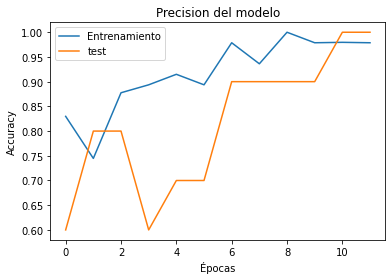

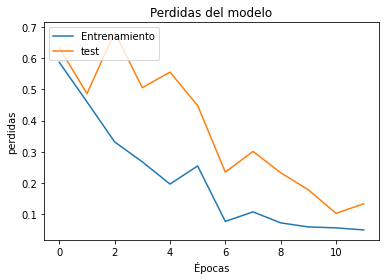

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento','test'], loc='upper left')
plt.show()

Otro tipo de gráfico

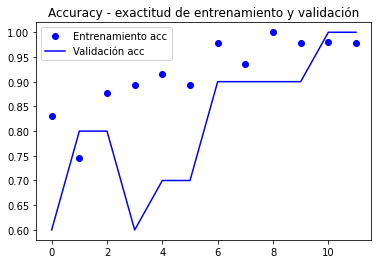

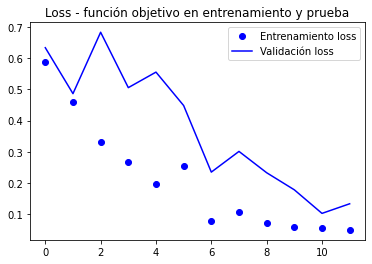

In [19]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

ep = range(len(acc))

plt.plot(ep, acc, 'bo', label='Entrenamiento acc')
plt.plot(ep, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')

plt.legend()
plt.figure()

plt.plot(ep, loss, 'bo', label='Entrenamiento loss')
plt.plot(ep, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')

plt.legend()
plt.show()

Guardamos el modelo y los pesos

In [20]:
cnn2.save('/content/TPBuscaYerba/modelo_final.h5')
cnn2.save_weights('/content/TPBuscaYerba/pesos_final.h5')

Proceso de predicción

In [21]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import numpy as np

In [22]:
modelo = '/content/TPBuscaYerba/modelo_final.h5'
pesos = '/content/TPBuscaYerba/pesos_final.h5'
cnn2 = load_model(modelo)
cnn2.load_weights(pesos)

In [23]:
def predecir (file):
  x=load_img(file, target_size=(longitud,altura))
  x=img_to_array(x)
  x=np.expand_dims(x,axis=0)
  output=cnn2.predict(x)
  #print(output)
  respuesta=np.argmax(output)
  
  if output == 1:
    print('sana')
  else:
    print('enferma')
  return 

predecir('/content/TPBuscaYerba/ds4/validacion/enfermas/Colletotrichum 12.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/enfermas/Colletotrichum 4.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/enfermas/Colletotrichum 7.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/sanas/nu-9.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/sanas/sana-17.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/sanas/sana-18.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/enfermas/Colletotrichum 13.jpg')
predecir('/content/TPBuscaYerba/ds4/validacion/sanas/nu-10.jpg')

enferma
enferma
enferma
sana
sana
sana
enferma
sana
